In [1]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from datetime import datetime

warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
#https://discord.com/channels/1134059900666916935/1283610000484208670

In [2]:
import re
import pandas as pd
from datetime import datetime

# Job dictionary and spec ranges
job_dict = {
    "허": "허밋", "시": "시프", "썬": "썬콜", "불독": "불독",
    "프": "프리스트", "레": "레인저", "저": "저격수",
    "용": "용기사", "크": "크루세이더", "나": "나이트"
}
job_spec_ranges = {
    "용": (3000, 6000), "크": (2000, 6000), "나": (2000, 6000),
    "허": (1500, 3500), "시": (1500, 3500), "썬": (500, 1000),
    "불독": (500, 1000), "프": (500, 1000), "레": (2000, 4000),
    "저": (2000, 4000)
}
level_min, level_max = 80, 200

# Regex patterns
time_pattern = r"(오전|오후) \d{1,2}:\d{2}"
job_pattern = r"(\d{2,3})\s?(" + "|".join(job_dict.keys()) + r")"
spec_pattern = r"(\d{3,4})"
map_pattern = r"(망용둥|위용둥|와협|불와둥|협동|레와둥|붉켄|검켄|푸켄|불어전|물어전|오징어|망둥어|듀파|갈림길|골짜기)"

def extract_level_and_spec(text, job_match_end, level_range, spec_range):
    """
    Extracts level and spec values independently, ensuring they meet respective criteria.
    Prioritizes proximity to the job match for level extraction.
    """
    # Extract all numbers in the text
    numbers = [(int(x), match.start()) for match in re.finditer(r"\b\d{2,4}\b", text) for x in [match.group()]]

    # Prioritize level extraction by proximity to the job match
    level = None
    spec = None
    for num, position in numbers:
        if level is None and level_range[0] <= num <= level_range[1]:
            level = num
        elif spec is None and spec_range[0] <= num <= spec_range[1]:
            spec = num

    # Ensure that the level and spec are distinct
    if level and spec and level == spec:
        spec = None  # Reset spec if it overlaps with level
    return level, spec

def collect_initial_data(file_path):
    """
    Collects and preprocesses the initial data from a file.
    """
    columns = ["party_id", "time", "level", "job", "spec", "map", "date", "valid"]
    df = pd.DataFrame(columns=columns)
    today_date = datetime.now().strftime("%Y-%m-%d")
    party_id = 0  # Initialize party ID

    with open(file_path, "r", encoding="utf-8") as file:
        data = file.read()

    # Split data by "오늘" to process each block
    blocks = data.split("오늘")
    for block in blocks[1:]:
        # Extract time
        time_match = re.search(time_pattern, block)
        time = time_match.group(0) if time_match else None

        # Extract map
        map_match = re.search(map_pattern, block)
        map_name = map_match.group(0) if map_match else None

        # Extract job, level, and spec
        job_matches = re.finditer(job_pattern, block)
        for job_match in job_matches:
            job_short = job_match.group(2)
            job_full = job_dict.get(job_short, "Unknown")
            spec_search_area = block[job_match.end():]

            # Extract level and spec using the updated method
            level, spec = extract_level_and_spec(spec_search_area, job_match.end(), (level_min, level_max), job_spec_ranges.get(job_short, (None, None)))

            # Validate level and spec
            valid = True
            if spec is None or level is None:
                valid = False

            # Append data to DataFrame
            df = pd.concat([
                df,
                pd.DataFrame([{
                    "party_id": party_id,
                    "time": time,
                    "level": level,
                    "job": job_full,
                    "spec": spec,
                    "map": map_name,
                    "date": today_date,
                    "valid": valid
                }])
            ], ignore_index=True)
        party_id += 1

    # Remove duplicates within the same party_id
    df = df.drop_duplicates(subset=["party_id", "level", "job", "spec"])

    # Remove duplicates across different party_id's
    df = df.drop_duplicates(subset=["level", "job", "spec"])
    
    output_file = df.to_csv(file_path.replace('.txt', '.csv'), index=False)
    print(f"Initial data saved as {output_file}")
    return df

def reprocess_data(df, file_path):
    """
    Reprocesses data by removing outliers and recalculating metrics.
    """
    # Compute average spec-to-level ratio for valid rows by job
    df["spec_to_level"] = df.apply(
        lambda row: row["spec"] / row["level"] if pd.notna(row["spec"]) and pd.notna(row["level"]) else None,
        axis=1
    )
    
    valid_df = df[(df["valid"] == True) & (df["spec_to_level"].notna())]
    average_ratios = valid_df.groupby("job")["spec_to_level"].mean().reset_index()
    average_ratios.rename(columns={"spec_to_level": "average_spec_to_level"}, inplace=True)

    # Merge back the average spec-to-level ratio to the main DataFrame
    df = df.merge(average_ratios, on="job", how="left")

    # Mark outliers based on percentage difference being more than 20%
    df["spec_to_level_outlier"] = (
        abs(df["spec_to_level"] - df["average_spec_to_level"]) / df["average_spec_to_level"] > 0.2
    )
    # Set spec and average_spec_to_level to NaN if outlier condition is true
    df.loc[df["spec_to_level_outlier"] == True, ["spec", "average_spec_to_level"]] = None

    # Remove rows where spec_to_level is 20% lower or 20% higher than the average for the job
    initial_row_count = len(df)
    df = df[
        (df["spec_to_level"] >= 0.8 * df["average_spec_to_level"]) & 
        (df["spec_to_level"] <= 1.2 * df["average_spec_to_level"])
    ]
    final_row_count = len(df)

    # Recalculate refined average spec-to-level ratio for valid rows by job
    refined_valid_df = df[(df["valid"] == True) & (df["spec_to_level"].notna())]
    refined_average_ratios = refined_valid_df.groupby("job")["spec_to_level"].mean().reset_index()
    refined_average_ratios.rename(columns={"spec_to_level": "refined_average_spec_to_level"}, inplace=True)

    # Merge back the refined averages into the main DataFrame
    df = df.merge(refined_average_ratios, on="job", how="left")

    # Save the DataFrame to a CSV file
    refined_output_file = file_path.replace('.txt', '_processed.csv')
    df.to_csv(refined_output_file, index=False)

    print(f"Refined data saved as {refined_output_file}")
    print(f"Rows removed: {initial_row_count - final_row_count}")
    return df

def process_file(file_path):
    """
    Wrapper function to process a file through both collection and reprocessing.
    """
    df = collect_initial_data(file_path)
    reprocessed_df = reprocess_data(df, file_path)
    return reprocessed_df

# Run the process
file_name = "1209.txt"  # Replace with your file path
process_file(file_name)


Initial data saved as None
Refined data saved as 1209_processed.csv
Rows removed: 244


,party_id,time,level,job,spec,map,date,valid,spec_to_level,average_spec_to_level,spec_to_level_outlier,refined_average_spec_to_level
0,8,오전 12:42,143,저격수,3800,망용둥,2024-12-10,True,26.573427,24.894178,False,24.894178
1,8,오전 12:42,110,용기사,4639,망용둥,2024-12-10,True,42.172727,38.113634,False,36.411690
2,18,오전 12:43,137,용기사,4950,망용둥,2024-12-10,True,36.131387,38.113634,False,36.411690
3,52,오전 12:45,121,레인저,2760,망용둥,2024-12-10,True,22.809917,22.752900,False,24.023770
4,75,오전 12:46,110,허밋,2050,망용둥,2024-12-10,True,18.636364,17.781655,False,16.922266
5,85,오전 12:47,103,저격수,2650,와협,2024-12-10,True,25.728155,24.894178,False,24.894178
6,95,오전 12:48,122,썬콜,900,망용둥,2024-12-10,True,7.377049,6.657136,False,6.657136
7,99,오전 12:51,153,용기사,5250,None,2024-12-10,True,34.313725,38.113634,False,36.411690
8,143,오전 12:53,141,크루세이더,3753,망둥어,2024-12-10,True,26.617021,31.936422,False,31.936422
9,147,오전 12:53,95,썬콜,638,붉켄,2024-12-10,True,6.715789,6.657136,False,6.657136


In [3]:
df = pd.read_csv("1209.csv")
df

,party_id,time,level,job,spec,map,date,valid
0,0,오전 12:42,131.0,용기사,NaN,와협,2024-12-10,False
1,0,오전 12:42,98.0,불독,NaN,와협,2024-12-10,False
2,0,오전 12:42,98.0,레인저,NaN,와협,2024-12-10,False
3,0,오전 12:42,NaN,프리스트,NaN,와협,2024-12-10,False
4,1,오전 12:42,123.0,용기사,NaN,망둥어,2024-12-10,False
...,...,...,...,...,...,...,...,...
275,448,오후 7:16,96.0,크루세이더,3550.0,듀파,2024-12-10,True
276,448,오후 7:16,112.0,나이트,2742.0,듀파,2024-12-10,True
277,452,오후 7:16,NaN,나이트,2400.0,골짜기,2024-12-10,False
278,452,오후 7:16,NaN,레인저,2400.0,골짜기,2024-12-10,False


In [4]:
processed_df = pd.read_csv("1209_processed.csv")
processed_df

,party_id,time,level,job,spec,map,date,valid,spec_to_level,average_spec_to_level,spec_to_level_outlier,refined_average_spec_to_level
0,8,오전 12:42,143,저격수,3800,망용둥,2024-12-10,True,26.573427,24.894178,False,24.894178
1,8,오전 12:42,110,용기사,4639,망용둥,2024-12-10,True,42.172727,38.113634,False,36.411690
2,18,오전 12:43,137,용기사,4950,망용둥,2024-12-10,True,36.131387,38.113634,False,36.411690
3,52,오전 12:45,121,레인저,2760,망용둥,2024-12-10,True,22.809917,22.752900,False,24.023770
4,75,오전 12:46,110,허밋,2050,망용둥,2024-12-10,True,18.636364,17.781655,False,16.922266
5,85,오전 12:47,103,저격수,2650,와협,2024-12-10,True,25.728155,24.894178,False,24.894178
6,95,오전 12:48,122,썬콜,900,망용둥,2024-12-10,True,7.377049,6.657136,False,6.657136
7,99,오전 12:51,153,용기사,5250,NaN,2024-12-10,True,34.313725,38.113634,False,36.411690
8,143,오전 12:53,141,크루세이더,3753,망둥어,2024-12-10,True,26.617021,31.936422,False,31.936422
9,147,오전 12:53,95,썬콜,638,붉켄,2024-12-10,True,6.715789,6.657136,False,6.657136


In [5]:
hermit = df[(df['job'] == '허밋')]
hermit
hermit_vaild = hermit[hermit['valid'] == True]
hermit_vaild

,party_id,time,level,job,spec,map,date,valid
74,75,오전 12:46,110.0,허밋,2050.0,망용둥,2024-12-10,True
112,137,오전 12:53,118.0,허밋,1600.0,듀파,2024-12-10,True
128,165,오전 2:05,112.0,허밋,1650.0,듀파,2024-12-10,True
134,179,오전 2:06,121.0,허밋,2190.0,망용둥,2024-12-10,True
154,220,오전 2:08,93.0,허밋,2263.0,골짜기,2024-12-10,True
165,229,오전 2:09,86.0,허밋,1600.0,듀파,2024-12-10,True
190,275,오후 7:10,99.0,허밋,1580.0,듀파,2024-12-10,True
239,380,오후 7:13,155.0,허밋,2850.0,망용둥,2024-12-10,True
253,407,오후 7:14,115.0,허밋,2081.0,망용둥,2024-12-10,True
272,448,오후 7:16,108.0,허밋,1674.0,듀파,2024-12-10,True


In [6]:
unique_maps = df["map"].unique()
print("Maps in the data:")
for map_name in unique_maps:
    print(map_name)

Maps in the data:
와협
망둥어
붉켄
검켄
불어전
망용둥
nan
협동
위용둥
레와둥
듀파
골짜기
오징어
갈림길
물어전


Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   party_id  280 non-null    int64  
 1   time      280 non-null    object 
 2   level     226 non-null    float64
 3   job       280 non-null    object 
 4   spec      86 non-null     float64
 5   map       231 non-null    object 
 6   date      280 non-null    object 
 7   valid     280 non-null    bool   
dtypes: bool(1), float64(2), int64(1), object(4)
memory usage: 15.7+ KB
None

Data Overview:
   party_id      time  level   job  spec  map        date  valid
0         0  오전 12:42  131.0   용기사   NaN   와협  2024-12-10  False
1         0  오전 12:42   98.0    불독   NaN   와협  2024-12-10  False
2         0  오전 12:42   98.0   레인저   NaN   와협  2024-12-10  False
3         0  오전 12:42    NaN  프리스트   NaN   와협  2024-12-10  False
4         1  오전 12:42  123.0   용기사   NaN  망둥어  2024-12-10  False

Map Freque

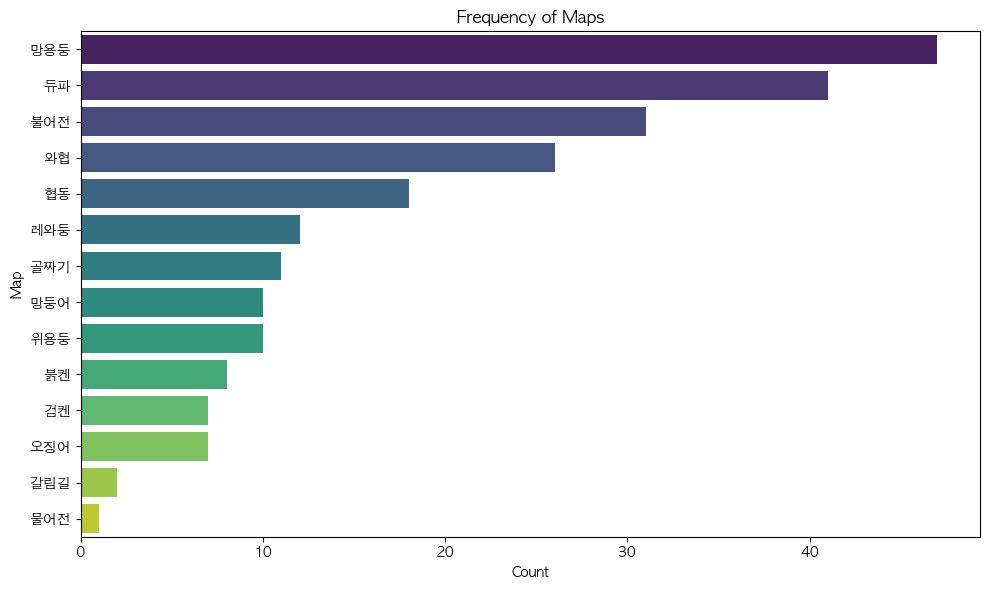

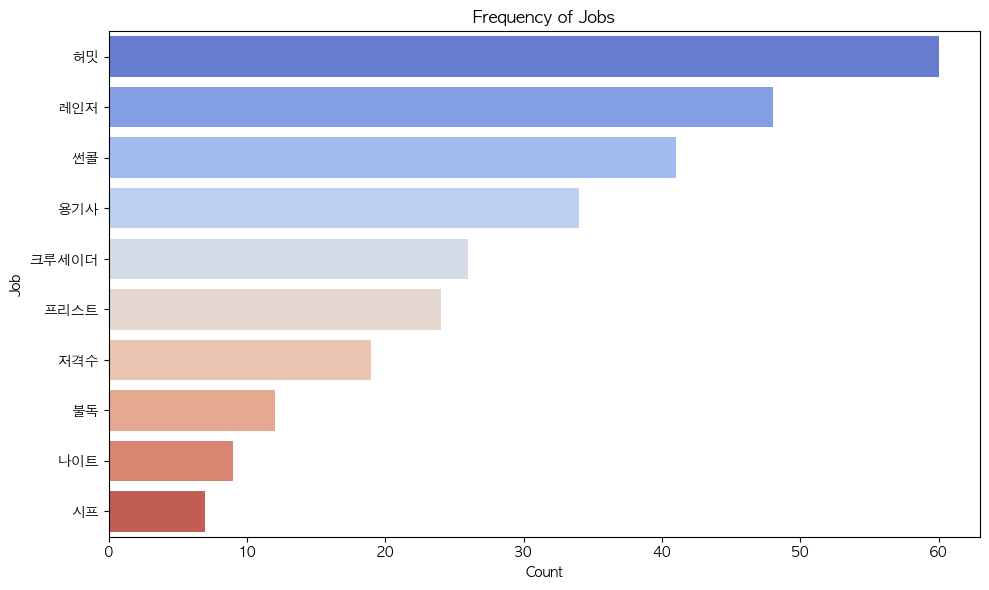

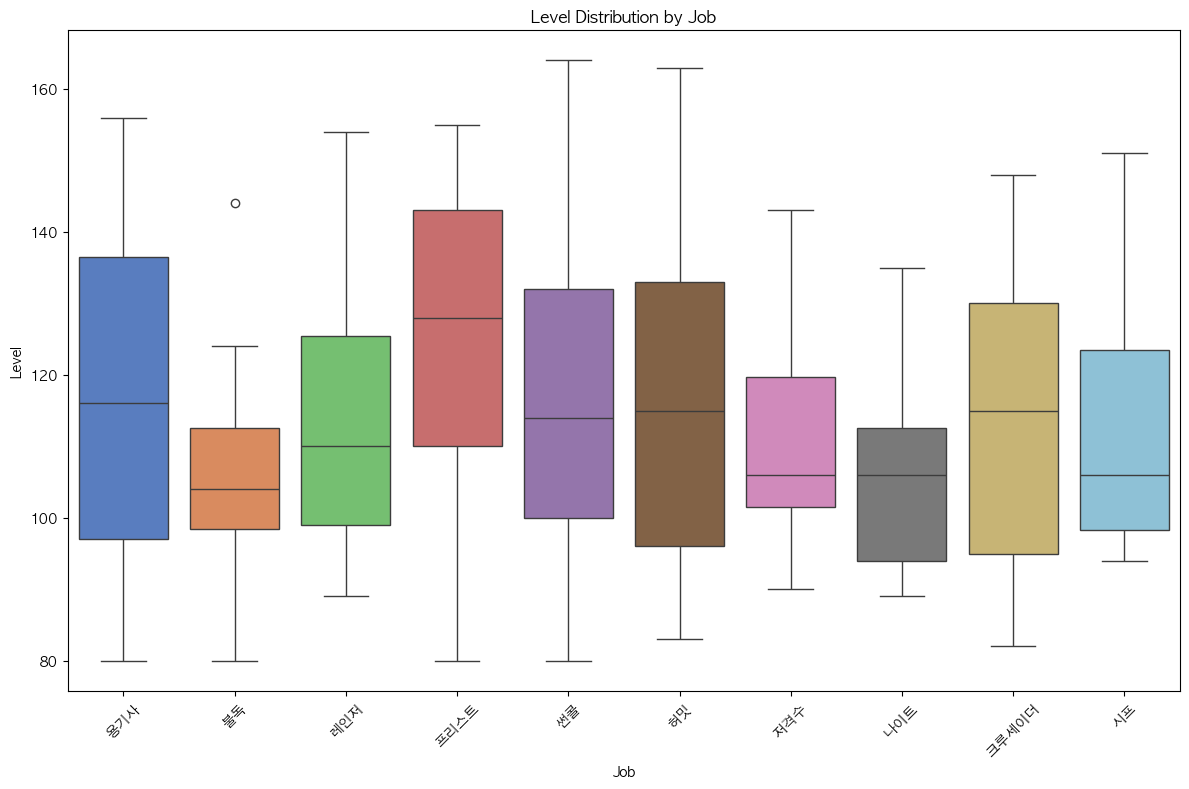

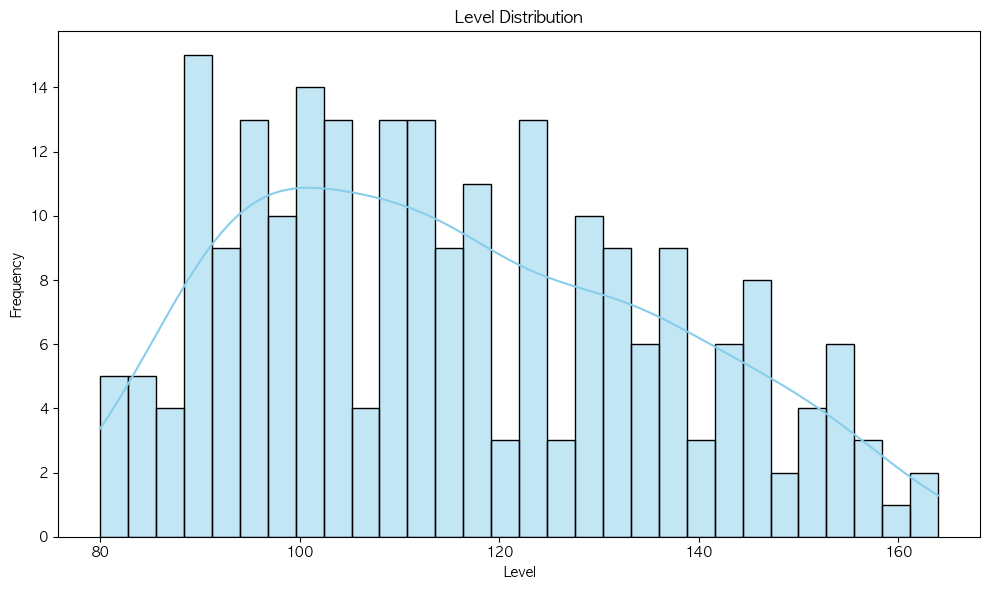

In [7]:
# Display basic information about the DataFrame
print("Basic Info:")
print(df.info())

print("\nData Overview:")
print(df.head())

# Count frequency of maps
map_counts = df["map"].value_counts()

print("\nMap Frequency:")
print(map_counts)

# Count frequency of jobs
job_counts = df["job"].value_counts()

print("\nJob Frequency:")
print(job_counts)

# Distribution of levels by job
print("\nLevel Statistics by Job:")
print(df.groupby("job")["level"].describe())

# Convert 'level' column to numeric for analysis
df["level"] = pd.to_numeric(df["level"], errors="coerce")

# 1. Map Distribution
plt.figure(figsize=(10, 6))
sns.countplot(y="map", data=df, order=map_counts.index, palette="viridis")
plt.title("Frequency of Maps")
plt.xlabel("Count")
plt.ylabel("Map")
plt.tight_layout()
plt.show()

# 2. Job Distribution
plt.figure(figsize=(10, 6))
sns.countplot(y="job", data=df, order=job_counts.index, palette="coolwarm")
plt.title("Frequency of Jobs")
plt.xlabel("Count")
plt.ylabel("Job")
plt.tight_layout()
plt.show()

# 3. Level Distribution by Job
plt.figure(figsize=(12, 8))
sns.boxplot(x="job", y="level", data=df, palette="muted")
plt.title("Level Distribution by Job")
plt.xlabel("Job")
plt.ylabel("Level")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Level Distribution Overall
plt.figure(figsize=(10, 6))
sns.histplot(df["level"], kde=True, bins=30, color="skyblue")
plt.title("Level Distribution")
plt.xlabel("Level")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


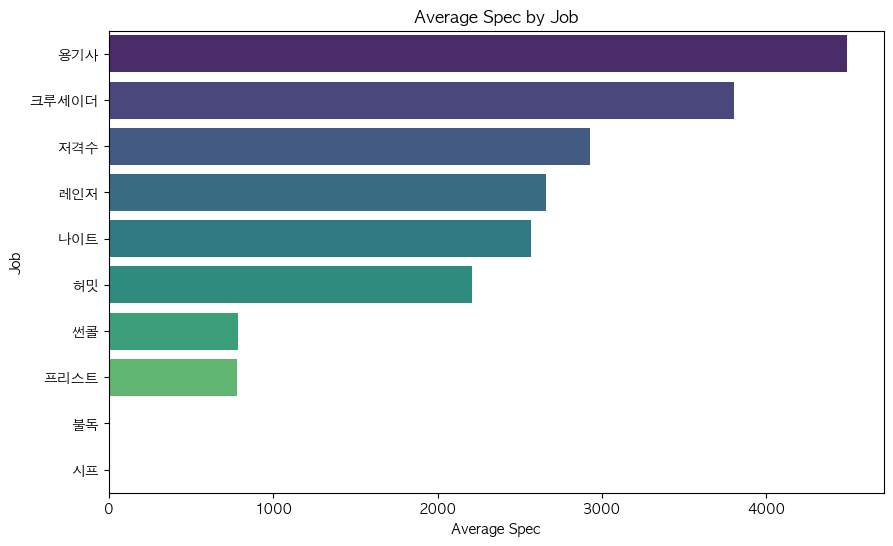

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the 'spec' column is numeric, replacing non-numeric values with NaN
df['spec'] = pd.to_numeric(df['spec'], errors='coerce')

# Calculate the average spec by job, ignoring NaN values
average_spec_by_job = df.groupby('job')['spec'].mean().reset_index()

# Fill NaN values with 0 for jobs with no spec data
average_spec_by_job['spec'] = average_spec_by_job['spec'].fillna(0)

# Ensure all jobs are represented, even if they have no spec data
all_jobs = list(job_dict.values())  # Ensure all jobs from job_dict are present
missing_jobs = [job for job in all_jobs if job not in average_spec_by_job['job'].values]

# Create a DataFrame for missing jobs with spec value set to 0
missing_jobs_df = pd.DataFrame({'job': missing_jobs, 'spec': [0]*len(missing_jobs)})

# Concatenate the missing jobs DataFrame with the existing DataFrame
average_spec_by_job = pd.concat([average_spec_by_job, missing_jobs_df], ignore_index=True)

# Sort the data for better visualization
average_spec_by_job = average_spec_by_job.sort_values('spec', ascending=False)

# Set up the visualizations
plt.figure(figsize=(10, 6))
sns.barplot(x='spec', y='job', data=average_spec_by_job, palette='viridis')

# Add labels and title
plt.xlabel('Average Spec')
plt.ylabel('Job')
plt.title('Average Spec by Job')

# Display the plot
plt.show()


In [9]:
def plot_job_frequency_by_map(df):
    # Count the number of occurrences of each job in each map
    job_map_counts = df.groupby(["map", "job"]).size().reset_index(name="count")
    
    # Create a pivot table for better visualization
    job_map_pivot = job_map_counts.pivot(index="map", columns="job", values="count").fillna(0)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(job_map_pivot, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Job Count'})
    plt.title("Job Frequency by Map")
    plt.ylabel("Map")
    plt.xlabel("Job")
    plt.show()

In [10]:
def plot_hermit_level_spec(df):
    # Filter the dataframe for "허밋"
    hermit_df = df[df["job"] == "허밋"]
    
    # Plot Level vs Spec for Hermit without including map
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=hermit_df, x="level", y="spec", s=100)
    plt.title("Hermit's Level vs Spec")
    plt.xlabel("Level")
    plt.ylabel("Spec")
    plt.show()

In [11]:
def plot_hermit_level_by_map(df):
    # Filter the dataframe for "허밋"
    hermit_df = df[df["job"] == "허밋"]
    
    # Plot Level by Map for Hermit
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=hermit_df, x="map", y="level", palette="Set2")
    plt.title("Hermit's Level by Map")
    plt.xlabel("Map")
    plt.ylabel("Level")
    plt.xticks(rotation=45)
    plt.show()


In [12]:
def plot_spec_to_level_ratio_by_job(df):
    # Compute the spec-to-level ratio
    df["spec_to_level"] = df.apply(
        lambda row: row["spec"] / row["level"] if pd.notna(row["spec"]) and pd.notna(row["level"]) else None,
        axis=1
    )
    
    # Plot spec-to-level ratio by job
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x="job", y="spec_to_level", palette="Set3")
    plt.title("Spec-to-Level Ratio by Job")
    plt.xlabel("Job")
    plt.ylabel("Spec-to-Level Ratio")
    plt.xticks(rotation=45)
    plt.show()


In [13]:
def plot_level_distribution_by_job(df):
    plt.figure(figsize=(12, 8))
    sns.histplot(data=df, x="level", hue="job", multiple="stack", bins=20, palette="Set2")
    plt.title("Distribution of Levels by Job")
    plt.xlabel("Level")
    plt.ylabel("Frequency")
    plt.show()


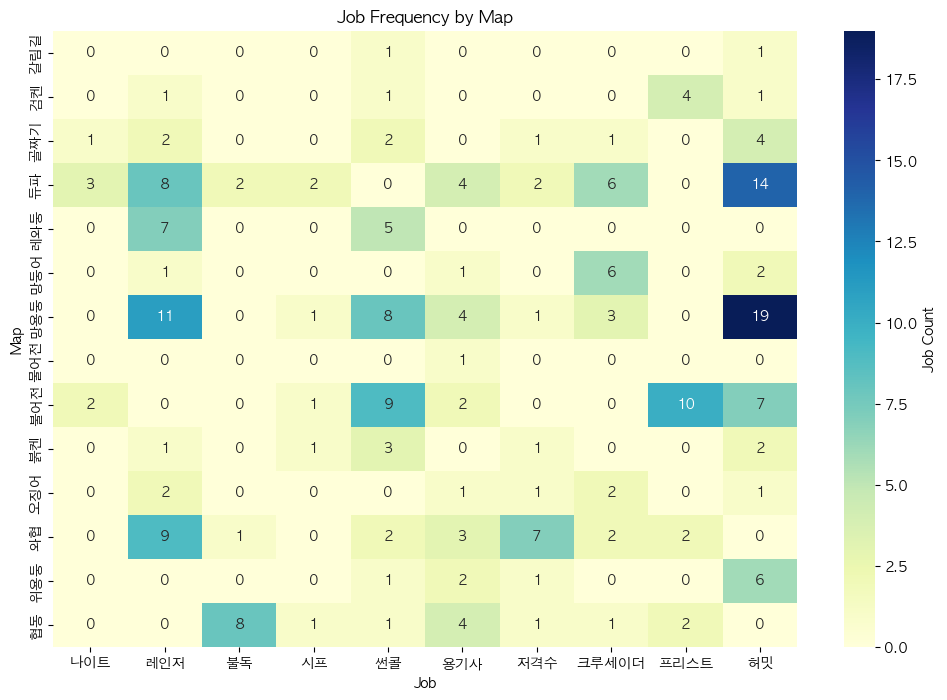

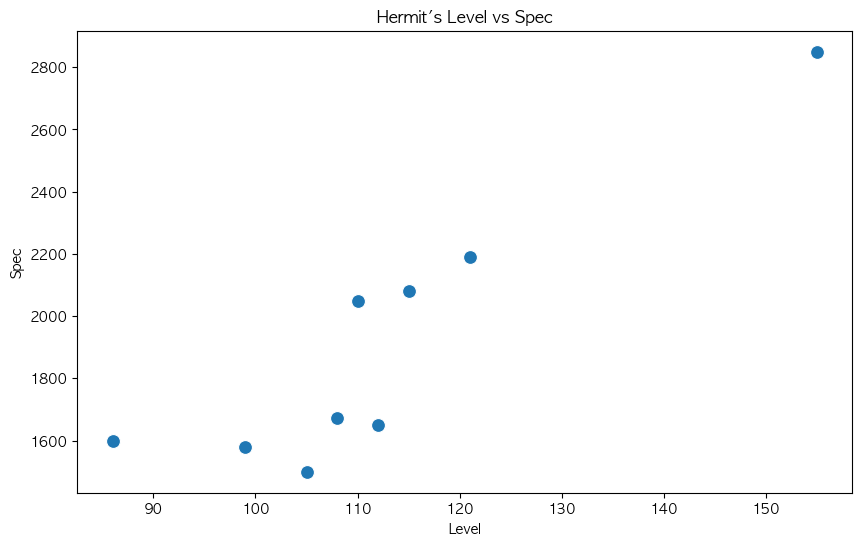

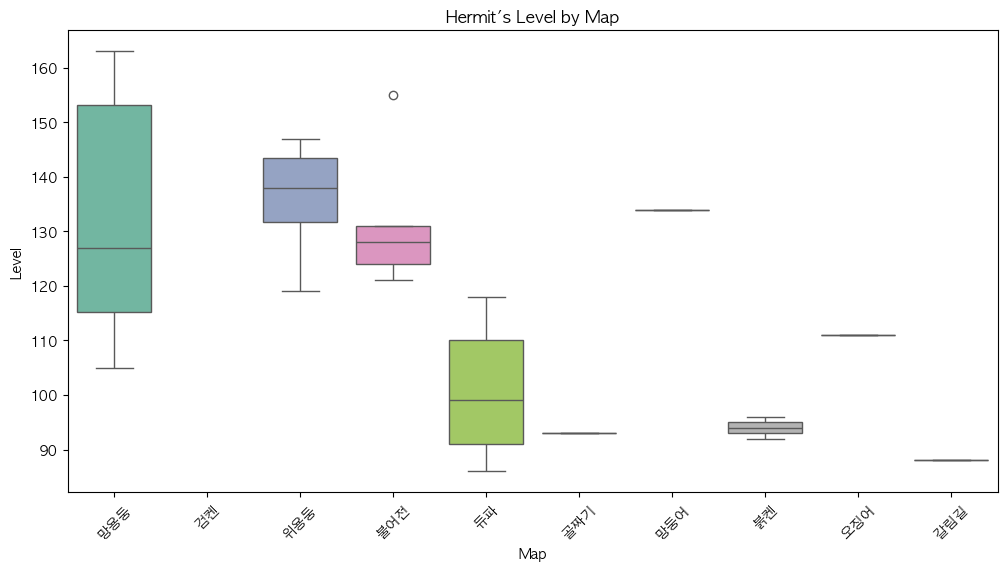

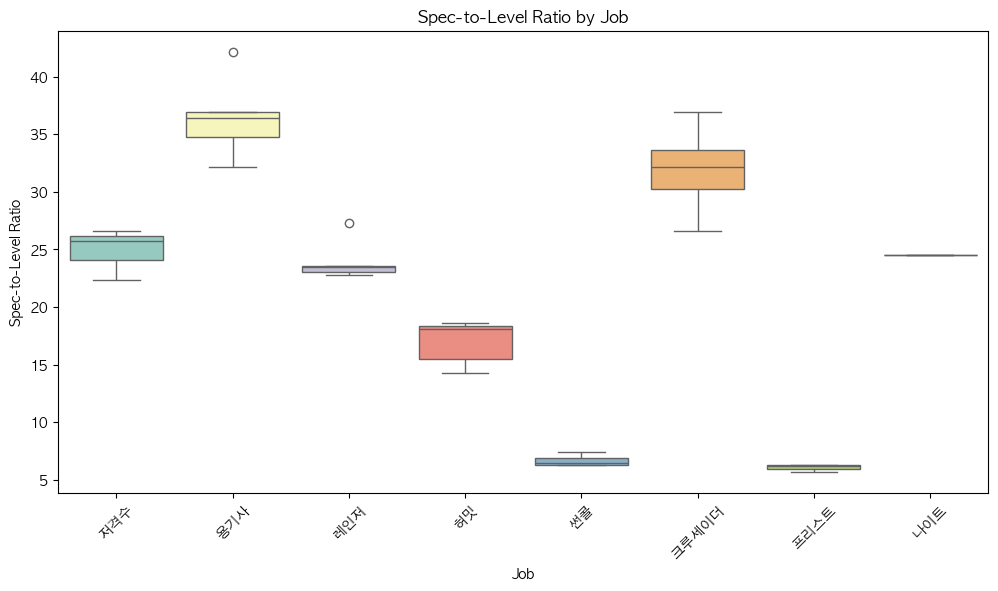

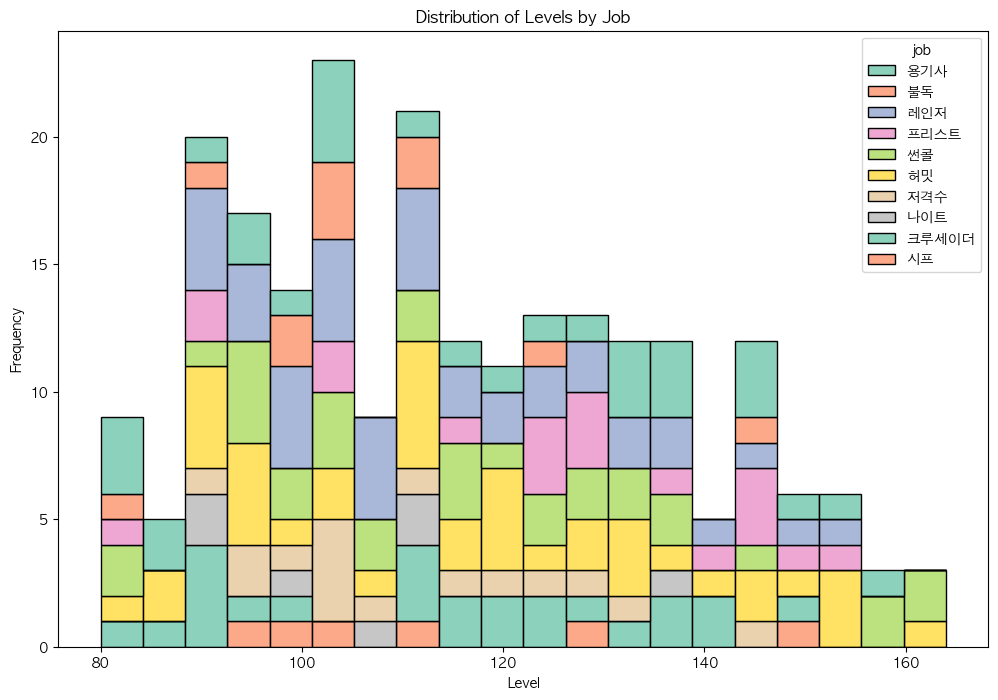

In [14]:
# Assuming `df` is your processed DataFrame
plot_job_frequency_by_map(df)
plot_hermit_level_spec(processed_df)
plot_hermit_level_by_map(df)
plot_spec_to_level_ratio_by_job(processed_df)
plot_level_distribution_by_job(df)

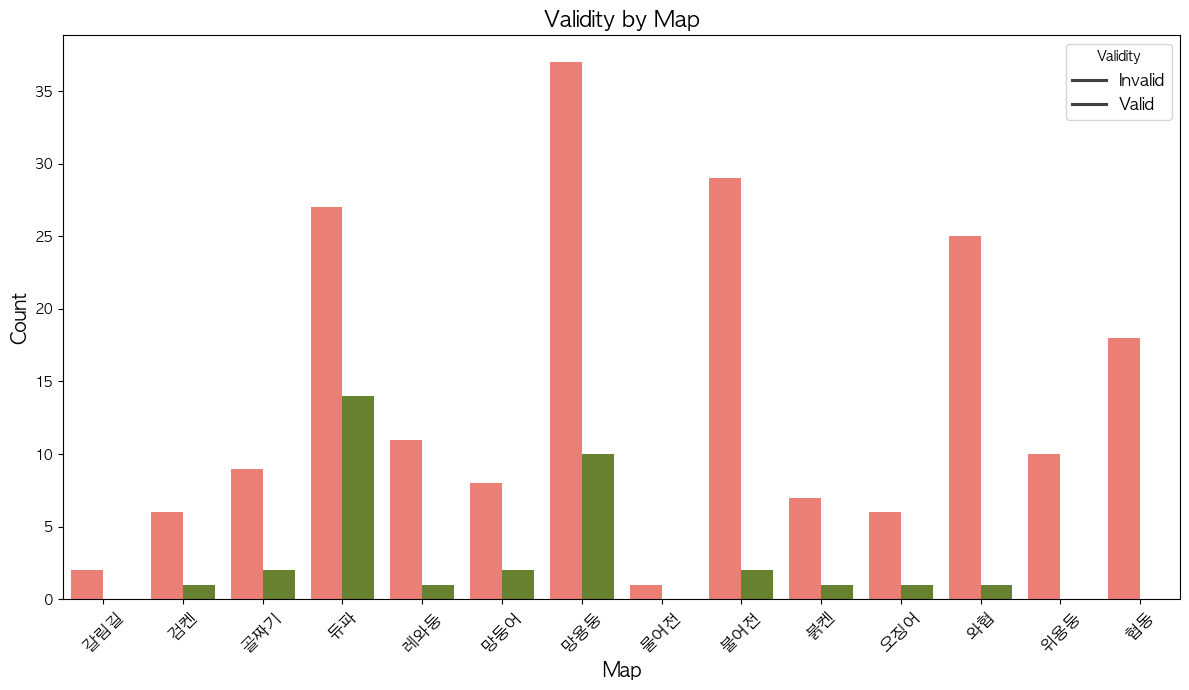

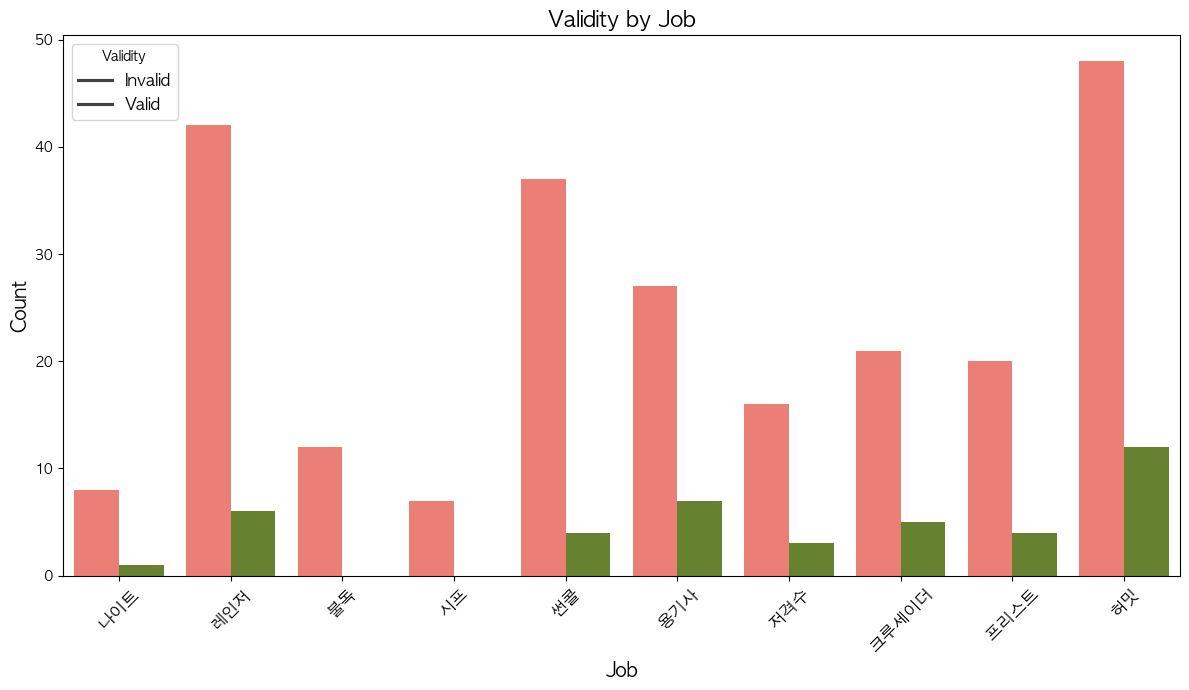

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_validity_by_map(df):
    """
    Visualizes the validity of the data by map using Seaborn.
    """
    # Count valid and invalid entries for each map
    validity_by_map = df.groupby(['map', 'valid']).size().reset_index(name='count')
    
    # Create a stacked bar chart
    plt.figure(figsize=(12, 7))
    sns.barplot(
        data=validity_by_map,
        x='map', y='count', hue='valid',
        palette=['#FF6F61', '#6B8E23']
    )
    plt.title('Validity by Map', fontsize=16)
    plt.xlabel('Map', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title='Validity', labels=['Invalid', 'Valid'], fontsize=12)
    plt.tight_layout()
    plt.show()

def visualize_validity_by_job(df):
    """
    Visualizes the validity of the data by job using Seaborn.
    """
    # Count valid and invalid entries for each job
    validity_by_job = df.groupby(['job', 'valid']).size().reset_index(name='count')
    
    # Create a stacked bar chart
    plt.figure(figsize=(12, 7))
    sns.barplot(
        data=validity_by_job,
        x='job', y='count', hue='valid',
        palette=['#FF6F61', '#6B8E23']
    )
    plt.title('Validity by Job', fontsize=16)
    plt.xlabel('Job', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title='Validity', labels=['Invalid', 'Valid'], fontsize=12)
    plt.tight_layout()
    plt.show()

# Example usage with your dataframe
visualize_validity_by_map(df)
visualize_validity_by_job(df)